In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
#from shapely.ops import unary_union
import pandas 
import geopandas
import time

thisyear = 2018

script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
data_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/districts_with_data/'
output_dir = data_dir

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/estimates/'.format(thisyear)
shapefiledir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

water_area_tol = 1 * 1000 * 1000
overlap_area_tract_tol = 22000
overlap_area_bg_tol = 4000
#smallest tract in US is Cook County, Illinois Tract 307.02 (area = 22,094 m^2)
#smallest block group in US is Miami-Dade County, FL, Census Tract 2703, block group 7 (area = 4,436 m^2)
equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163

scale = 1
map_buffer = 0.25 # extra room on each edge of the maps, in degres

#plt.rc('axes', prop_cycle=default_cycler)

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color_cycle = color_cycle + color_cycle
color_cycle = color_cycle + color_cycle

debug = 1
g = 0

print('ok')

ok


# Get congressional district shapefiles

WITH data on metro and city areas as a percentage of total district area.

This assumes that you have already run <code>districts-cities.ipynb</code>.

In [2]:
s = time.time()
print('reading congressional districts with urban/rural area data...')
cd_gdf = geopandas.read_file(data_dir+'cd116_with_areas_and_types_435.shp')

print('Fixing at-large districts by setting district number to 1...')
cd_gdf.loc[cd_gdf['CD116FP'] == 0, 'CD116FP'] = 1  # At-large districts will be called District 1

cd_gdf = cd_gdf.rename(columns = {'pct_metro_': 'pct_metro_area', 'pct_city_a': 'pct_city_area'})
cd_gdf.loc[:, 'CD116FP'] = cd_gdf['CD116FP'].apply(lambda x: int(x))
cd_gdf = cd_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Read {0:,.0f} districts in {1:,.1f} seconds.'.format(len(cd_gdf), e-s))
#sorted(cd_gdf[cd_gdf['CD116FP'] == 0]['STUSAB'].tolist())


reading congressional districts with urban/rural area data...
Fixing at-large districts by setting district number to 1...
Read 435 districts in 2.2 seconds.


## Load block groups (nationwide)

In [3]:
s = time.time()
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()

for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)

print('converting block group identifiers and coords to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: x[0:4]+'.'+x[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')
bg_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(bg_gdf['INTPTLAT'], errors='coerce')
bg_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(bg_gdf['INTPTLON'], errors='coerce')

#bg_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_gdf['NAME'], errors='coerce')
# bg_gdf = tract_gdf.sort_values(by='NAME')

print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))
bg_gdf = bg_gdf.set_index('GEOID')

e = time.time()
g = g + (e-s)
if (debug >= 1):
    print('Read {0:,.0f} census block groups in {1:,.1f} seconds!'.format(len(bg_gdf), e-s))

#bg_gdf.sample(1).T


	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
converting block group identifiers and coords to numeric...
assigning GEOID as index...
Read 217,739 census block groups in 122.6 seconds!


In [4]:
s = time.time()

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
state_codes_df = state_codes_df.rename(columns={'STATE': 'STATEFP'})
bg_gdf = bg_gdf.reset_index().merge(state_codes_df, how='left', on='STATEFP').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATEFP', 'County Code (FIPS)': 'COUNTYFP', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
bg_gdf = bg_gdf.reset_index().merge(county_names_df[['STATEFP', 'COUNTYFP', 'COUNTY_NAME']], how='left', on=['STATEFP', 'COUNTYFP']).set_index('GEOID')

e = time.time()
g = g + (e-s)
print('Added state and county names in {0:,.1f} seconds!'.format(e-s))


looking up state names from numbers...
looking up county names from numbers...
Added state and county names in 13.4 seconds!


## Get population data, and join onto shapefiles

In [5]:
s = time.time()
print('reading ACS5 census data for {0:.0f}...'.format(thisyear))
acs5_estimates_df = pandas.read_csv(acs5_dir+'estimates_acs{0:}_tract_bg_gerrymandering.csv'.format(thisyear), index_col='GEOID')

print('joining population data onto block group shapefiles...')
bg_gdf = bg_gdf.join(acs5_estimates_df[['B01001_001', 'Geography Name']], how='left')
bg_gdf = bg_gdf.rename(columns={'B01001_001': 'total_population'})

e = time.time()
g = g + (e-s)
print('\nadded ACS5 census data to {0:,.0f} block groups in {1:,.0f} seconds!'.format(len(bg_gdf), e-s))


reading ACS5 census data for 2018...
joining population data onto block group shapefiles...

added ACS5 census data to 217,739 block groups in 3 seconds!


# Geo-match congressional districts

If a tract overlaps with only one district, match that tract to its district.
If it overlaps multiple districts, divide into block groups and match each block group to its matching districts.

# Geo-match block groups to the congressional districts they are in

## Get what has been matched so far

In [6]:
s = time.time()
print('reading districts that have been matched so far...')
assembler_df = pandas.read_csv(data_dir+'block_group_with_district_1_2.csv', encoding='utf-8', index_col='GEOID')
assembler_gdf = geopandas.GeoDataFrame(assembler_df.join(bg_gdf.geometry))
assembler_gdf.crs = bg_gdf.crs


cd_gdf = cd_gdf[~cd_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]
bg_gdf = bg_gdf[~bg_gdf['STUSAB'].isin(assembler_gdf['STUSAB'].drop_duplicates().tolist())]

print('backing up...')
cd_gdf_bk = cd_gdf
bg_gdf_bk = bg_gdf
assembler_gdf_bk = assembler_gdf

e = time.time()
g = g + (e-s)
print('Kept {0:,.0f} block groups in {1:,.1f} seconds!'.format(len(bg_gdf),e-s))




reading districts that have been matched so far...
backing up...
Kept 208,970 block groups in 0.6 seconds!


## States with 3 or more districts

These are harder, because first we have to know which block groups overlap multiple districts.

Create a function to mark those.

### Create function to mark block groups with the districts they overlap

In [7]:
def mark_block_groups_with_districts_bitmask_values(block_group_info_gdf, congressional_district_info_gdf, debug=0):    
    working_with_state = block_group_info_gdf['STATE_NAME'].head(1).values[0]
    
    marked_s = pandas.Series()
    
    equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
    cnt = 0
    if (debug > 0):    
        print('\tAssigning bitmask values to block groups in {0:}...'.format(working_with_state))
    
    for ix, thisrow in block_group_info_gdf.iterrows():    
        bitmasker = 0
        if (debug > 1):
            print(ix)
            print('\t\tMatching {0:}, {1:} census tract {2:}, block group {3:}...'.format(thisrow['STATE_NAME'], thisrow['COUNTY_NAME'], thisrow['TRACTCE'], thisrow['BLKGRPCE']))
            print('\n')
        if ((np.mod(cnt,100) == 0) | (cnt == len(block_group_info_gdf) - 1)):
            if (debug > 1):
                print('\t\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
            else:
                print('\t\tprocessing row {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(bg_gdf[bg_gdf['STUSAB'] == this_state])))
                
        for jx, thatrow in congressional_district_info_gdf.iterrows():
            if (thisrow.geometry.intersects(thatrow.geometry)):
                this_district_overlap_area = block_group_info_gdf[block_group_info_gdf.index == ix].to_crs(equal_area_crs).geometry.values[0].intersection(congressional_district_info_gdf[congressional_district_info_gdf.index == jx].to_crs(equal_area_crs).geometry.values[0]).area
                if (this_district_overlap_area >= overlap_area_bg_tol):
                    bitmasker = bitmasker + 2**(thatrow['CD116FP']-1)
                    if (debug > 1):
                        print('\t\t\t\tIntersects District {0:.0f} with overlap area {1:,.1f} km^2...'.format(thatrow['CD116FP'], this_district_overlap_area/1000000))               
        marked_s.loc[ix] = bitmasker
        cnt = cnt + 1
        
    return marked_s
print('defined district-marking function!')


defined district-marking function!


## Find block group / district overlaps, assign districts to non-overlapping block groups

Uses function defined above

In [8]:
s = time.time()

print('getting from backup...')
bg_gdf = bg_gdf_bk
assembler_gdf = assembler_gdf_bk

e = time.time()
g = g + (e-s)

for this_state in ['NE', 'NM', 'AR', 'KS', 'MS', 'NV', 'UT', 'CT', 'OK', 'OR', 'KY', 'LA']:
    s = time.time()
    state_full_name = bg_gdf[bg_gdf['STUSAB'] == this_state]['STATE_NAME'].values[0]
    print('\n')
    print('Processing {0:}...'.format(state_full_name))
    assembler_i_gdf = bg_gdf[bg_gdf['STUSAB'] == this_state]

    district_bitmask_values_s = mark_block_groups_with_districts_bitmask_values(
        bg_gdf[bg_gdf['STUSAB'] == this_state][['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population', 'geometry']], 
        cd_gdf[cd_gdf['STUSAB'] == this_state][['STUSAB', 'CD116FP', 'geometry']], 
        debug
    )
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask_values = district_bitmask_values_s)
    
    
    if (debug > 0):
        print('\tconverting bitmask values to human-readable bitmasks...')        
    nDistrictsForBitmaskeration = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116FP'].max()
    assembler_i_gdf = assembler_i_gdf.assign(congressional_districts_bitmask = 
                                             assembler_i_gdf['congressional_districts_bitmask_values'].apply(lambda x: 'x'+np.binary_repr(int(x)).zfill(nDistrictsForBitmaskeration)[::-1])
                                            )

    if (debug > 0):
        print('\tcounting number of districts each block group overlaps...')        
    
    assembler_i_gdf = assembler_i_gdf.assign(nDistricts = 
                                             assembler_i_gdf['congressional_districts_bitmask'].apply(lambda x: x[1:].count("1"))
                                            )
    if (debug > 0):
        print('\tassigning congressional district to each block group with only one overlap...')
        
    assembler_i_gdf = assembler_i_gdf.assign(block_based_district = np.nan)
    assembler_i_gdf.loc[
        assembler_i_gdf['nDistricts'] == 1, 
        'block_based_district'] = assembler_i_gdf[
                        assembler_i_gdf['nDistricts'] == 1
                    ]['congressional_districts_bitmask'].apply(lambda x: x.find("1"))
    
    print('\t...-1 otherwise...')
    assembler_i_gdf.loc[assembler_i_gdf['nDistricts'] > 1, 'block_based_district'] = -1
    
    if (debug > 0):
        print('\tjoining {0:} to the rest of the assembler dataframe...'.format(state_full_name))
    assembler_gdf = pandas.concat((assembler_gdf, assembler_i_gdf), axis=0, sort=False)
    if (debug > 0):
        print("\n")
    e = time.time()
    g = g + (e-s)

    print('matched districts for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))

# print('backing up...')
# assembler_gdf_bk2 = assembler_gdf

print('GRAND TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

# print(assembler_gdf.groupby('STUSAB').size())
# print(assembler_gdf.groupby(['STUSAB', 'nDistricts']).size())
#print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# assembler_gdf.sample(2).T

#assembler_gdf[assembler_gdf['STUSAB'] == this_state].groupby('congressional_districts_bitmask').size()


getting from backup...


Processing Nebraska...
	Assigning bitmask values to block groups in Nebraska...
		processing row 1 of 1,633...
		processing row 101 of 1,633...
		processing row 201 of 1,633...
		processing row 301 of 1,633...
		processing row 401 of 1,633...
		processing row 501 of 1,633...
		processing row 601 of 1,633...
		processing row 701 of 1,633...
		processing row 801 of 1,633...
		processing row 901 of 1,633...
		processing row 1,001 of 1,633...
		processing row 1,101 of 1,633...
		processing row 1,201 of 1,633...
		processing row 1,301 of 1,633...
		processing row 1,401 of 1,633...
		processing row 1,501 of 1,633...
		processing row 1,601 of 1,633...
		processing row 1,633 of 1,633...
	converting bitmask values to human-readable bitmasks...
	counting number of districts each block group overlaps...
	assigning congressional district to each block group with only one overlap...
	...-1 otherwise...
	joining Nebraska to the rest of the assembler dataframe...


matched di

		processing row 1,201 of 2,585...
		processing row 1,301 of 2,585...
		processing row 1,401 of 2,585...
		processing row 1,501 of 2,585...
		processing row 1,601 of 2,585...
		processing row 1,701 of 2,585...
		processing row 1,801 of 2,585...
		processing row 1,901 of 2,585...
		processing row 2,001 of 2,585...
		processing row 2,101 of 2,585...
		processing row 2,201 of 2,585...
		processing row 2,301 of 2,585...
		processing row 2,401 of 2,585...
		processing row 2,501 of 2,585...
		processing row 2,585 of 2,585...
	converting bitmask values to human-readable bitmasks...
	counting number of districts each block group overlaps...
	assigning congressional district to each block group with only one overlap...
	...-1 otherwise...
	joining Connecticut to the rest of the assembler dataframe...


matched districts for 2,585 block groups in CT in 1 minutes 55 seconds!


Processing Oklahoma...
	Assigning bitmask values to block groups in Oklahoma...
		processing row 1 of 2,965...
		processi

## Assign districts to block groups that overlap multiple districts

See examination sections below

In [9]:
print('Assigning districts based on examination to block groups that overlap multiple districts...')

# # NEBRASKA
assembler_gdf.loc['15000US310519778001', 'block_based_district'] = 3
assembler_gdf.loc['15000US310519778003', 'block_based_district'] = 1
assembler_gdf.loc['15000US311530106182', 'block_based_district'] = 2
assembler_gdf.loc[['15000US311530102082', '15000US311530102051'], 'block_based_district'] = 1
assembler_gdf.loc['15000US311530102032', 'block_based_district'] = 2
assembler_gdf.loc['15000US311530102033', 'block_based_district'] = 1
assembler_gdf.loc['15000US311530106183', 'block_based_district'] = 2
# Fix to keep districts contiguous and well-mapped to actual districts
assembler_gdf.loc['15000US311530106183', 'block_based_district'] = 1


# # NEW MEXICO
assembler_gdf.loc[['15000US350019407001', '15000US350010038073'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US350010046022', '15000US350010038071'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US350010040012', '15000US350010008012'], 'block_based_district'] = 1
assembler_gdf.loc['15000US350619703031', 'block_based_district'] = 2
assembler_gdf.loc['15000US350619703032', 'block_based_district'] = 1
assembler_gdf.loc[['15000US350619701011', '15000US350619703013'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US350619703012', '15000US350619703014', '15000US350619703022'], 'block_based_district'] = 2
assembler_gdf.loc['15000US350430110002', 'block_based_district'] = 3
assembler_gdf.loc['15000US350430111002', 'block_based_district'] = 1
assembler_gdf.loc[['15000US350010047461', '15000US350010047462', '15000US350019406003'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US350010047201', '15000US350010047521'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US350430111001', '15000US350430111003', '15000US350019406001', '15000US350430107022'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US350430107164', '15000US350430106011', '15000US350430106012', '15000US350430106022'], 'block_based_district'] = 3
assembler_gdf.loc['15000US350490103121', 'block_based_district'] = 3
assembler_gdf.loc[['15000US350490103111', '15000US350490103122'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US350319731001', '15000US350319403001', '15000US350319403003', '15000US350319405001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US350410004011'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US350410004023'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US350410002001', '15000US350410001002', '15000US350410003001', '15000US350410003002', '15000US350410003004', '15000US350410001003', '15000US350410003003'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US350410001004'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US350410001001'], 'block_based_district'] = 3
# Fix to keep districts contiguous and well-mapped to actual districts
assembler_gdf.loc['15000US350010047201', 'block_based_district'] = 3


# # ARKANSAS
assembler_gdf.loc[['15000US051299701002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US051299701003'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US050690023001', '15000US050690023002'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US050690023003', '15000US050690023004'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US050330202011', '15000US051310102012', '15000US050330202013', '15000US051310103021'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US051310103023', '15000US051310103022'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US051310101011', '15000US051310101013', '15000US051310101022', '15000US051011801003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US051310101012', '15000US050330204011', '15000US050330204014'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US050330204012'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US050330206001', '15000US050330206002', '15000US050330206003', '15000US050330206004', '15000US051011802001'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US050330201002', '15000US050330201003', '15000US051011802003', '15000US051011802002', '15000US051011801001'], 'block_based_district'] = 4
# Fixes to keep districts contiguous and well-mapped to actual districts
assembler_gdf.loc[['15000US051011802002', '15000US051310101022'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US051299701002', '15000US050690025001'], 'block_based_district'] = 1


# ##### KANSAS
assembler_gdf.loc['15000US201459703001', 'block_based_district'] = 2
assembler_gdf.loc[['15000US201211004001', '15000US201211001001', '15000US201211002002'], 'block_based_district'] = 3
assembler_gdf.loc['15000US201211005003', 'block_based_district'] = 2
assembler_gdf.loc[['15000US201170407011', '15000US201170701821'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US201170605101', '15000US201170901861', '15000US201170901863'], 'block_based_district'] = 1
# Fixes to keep districts contiguous and well-mapped to actual districts
assembler_gdf.loc['15000US201459703001', 'block_based_district'] = 1
assembler_gdf.loc['15000US201211004001', 'block_based_district'] = 2

# ###### MISSISSIPPI
assembler_gdf.loc[['15000US281059502001','15000US281059502003','15000US281059507002','15000US281059507003'], 'block_based_district'] = 1
assembler_gdf.loc['15000US281059502004', 'block_based_district'] = 3
assembler_gdf.loc[['15000US280239501002', '15000US280239503004', '15000US280239501004', '15000US280239503002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US280239501003', '15000US280239501005'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US280890303022', '15000US280890304002', '15000US280890304003'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US280890303024', '15000US280890309003', '15000US280890309004'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US280890301053', '15000US280490114002', '15000US280490027001'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US280890301051', '15000US280890301054', '15000US280490001001', '15000US280490004002', '15000US280490004003', '15000US280490027002', '15000US280490030003'], 'block_based_district'] = 3

# #### NEVADA
assembler_gdf.loc[['15000US320030061041'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US320030032531'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US320030029611', '15000US320030051051'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US320030068004', '15000US320030027072', '15000US320030028242', '15000US320030028272', '15000US320030050102', '15000US320030050171', '15000US320030050161', '15000US320030029621'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US320030032206', '15000US320030049172', '15000US320030003012', '15000US320030038002', '15000US320030038004'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US320030003013', '15000US320030038005', '15000US320030061042'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US320199608001', '15000US320030056134'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US320199609002', '15000US320199609004'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US320030075001', '15000US320030058231', '15000US320030032231'], 'block_based_district'] = 3
# Fixes to keep districts contiguous and well-mapped to actual districts
assembler_gdf.loc['15000US320030050161', 'block_based_district'] = 4

# ##### UTAH
assembler_gdf.loc['15000US490351101032', 'block_based_district'] = 2
assembler_gdf.loc[['15000US490111262021','15000US490111254033', '15000US490111262041'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US490111251022','15000US490111261042'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US490111261051','15000US490111261052'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US490111262032', '15000US490351101041'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US490351101042'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US490351128233', '15000US490490022051', '15000US490490022071', '15000US490490022073'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US490351128171', '15000US490351128181', '15000US490351128102', '15000US490490101131', '15000US490490101122'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US490399723001', '15000US490399725003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US490230102003', '15000US490230102002', '15000US490399722001', '15000US490399721004', '15000US490399721006', '15000US490351139071'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US490351135341', '15000US490351138032', '15000US490351135391', '15000US490351133074'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US490351145003', '15000US490351028021', '15000US490351044001'], 'block_based_district'] = 2
# Fixes to keep districts contiguous and well-mapped to actual districts
assembler_gdf.loc['15000US490351139071', 'block_based_district'] = 2
assembler_gdf.loc[['15000US490351101041', '15000US490351101042'], 'block_based_district'] = 3

# ##### CONNECTICUT
assembler_gdf.loc[['15000US090039800001', '15000US090035202012'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US090035202011'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US090075412002'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US090075412001', '15000US090075413003', '15000US090075414022'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US090012105003', '15000US090093513004', '15000US090093528001', '15000US090093519001'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US090012456001', '15000US090093514003', '15000US090093528002', '15000US090093519002', '15000US090093516024', '15000US090093517002', '15000US090093516022'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US090011102011'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US090011101001', '15000US090011102012', '15000US090011102021'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US090053101001', '15000US090053102002', '15000US090053108041'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US090053106022', '15000US090053108032'], 'block_based_district'] = 1
# Fixes to keep districts contiguous and well-mapped to actual districts
assembler_gdf.loc[['15000US090053108041', '15000US090075412001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US090093519002', '15000US090093516024', '15000US090093528002', '15000US090093514003', '15000US090093517002'], 'block_based_district'] = 3
assembler_gdf.loc['15000US090093516022', 'block_based_district'] = 5

#### OKLAHOMA
assembler_gdf.loc[['15000US401310504031', '15000US401310504091', '15000US401310504081', '15000US401310504051', '15000US401310504052'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US401310504061', '15000US401310504032'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US400370215003', '15000US400370206012'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US400370216001', '15000US400370216002'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US400173014061', '15000US400173014081'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US401091088011', '15000US401091087041'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US401091087033', '15000US401091087042', '15000US401091088021', '15000US401091088012', '15000US401091088013'], 'block_based_district'] = 4

# #### OREGON
assembler_gdf.loc[['15000US410510064042'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US410510067021', '15000US410510046012'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US410510050001', '15000US410510065012'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US410510069002', '15000US410510068011', '15000US410510065022'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US410510065011', '15000US410510058005', '15000US410510068022', '15000US410510049002'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US410510051002', '15000US410510072021'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US410333613002', '15000US410333613004', '15000US410333613003'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US410333608003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US410030102001'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US410050242003', '15000US410050242004', '15000US410050241001', '15000US410050237002', '15000US410050237004', '15000US410510064022', '15000US410510064033', '15000US410050222071'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US410059800001', '15000US410050241002', '15000US410050241003', '15000US410050230022', '15000US410050237001', '15000US410510064041', '15000US410510089021', '15000US410050222082', '15000US410050222072'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US410050242003', '15000US410050223011', '15000US410050221081', '15000US410050230011'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US410050223022', '15000US410050223023', '15000US410050223021', '15000US410050223012'], 'block_based_district'] = 5
# Fixes to keep districts contiguous and well-mapped to actual districts
assembler_gdf.loc[['15000US410050223012', '15000US410050223013'], 'block_based_district'] = 3


#### KENTUCKY
assembler_gdf.loc[['15000US212299303002'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US212150801032', '15000US212150802003', '15000US212150802002'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US212150801021', '15000US212150801022'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US211130606002','15000US211130604001','15000US211130606001','15000US211130604004','15000US211130604005'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US211110103161', '15000US211110111021', '15000US211110115202', '15000US211110116032', '15000US211110116033'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US211110103162', '15000US211110116012', '15000US211110116011', '15000US211110116041'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US210190310024', '15000US210190310025', '15000US210190311001', '15000US210190312001', '15000US210979501001', '15000US210979503002', '15000US210979503001', '15000US210979504002', '15000US210979504003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US210190311002'], 'block_based_district'] = 5
# Fixes to keep districts contiguous and well-mapped to actual districts
assembler_gdf.loc[['15000US212150801032', '15000US212150802003', '15000US212150801032', '15000US212150801032'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US212150801021', '15000US212150801022', '15000US212150802002'], 'block_based_district'] = 4



#### LOUISIANA
assembler_gdf.loc[['15000US220510278072', '15000US220510278092'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US220710017341', '15000US220710017301'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US220710017372', '15000US220710017451', '15000US220710017463', '15000US220710017244', '15000US220710017254'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US220710033023'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US220710133021', '15000US220719800001', '15000US220710076042'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US220710065001', '15000US220710054003', '15000US220710050001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US220710076051', '15000US220710046002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US220710119001', '15000US220710144001', '15000US220710126001', '15000US220710126002', '15000US220710125001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US220710114001', '15000US220710125002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US220710129001'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US220710129002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US220510210002', '15000US220510246001', '15000US220510249002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US220510236003', '15000US220510242011', '15000US220510244001', '15000US220510244002', '15000US220510248003', '15000US220510238001', '15000US220510236002', '15000US220510205153'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US221059538001', '15000US221059540012'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US221059539001', '15000US221059539003', '15000US221059540021' ], 'block_based_district'] = 5
assembler_gdf.loc[['15000US220570218001', '15000US220570218002', '15000US220570219022', '15000US221090017002', '15000US221090015002', '15000US221090015003'], 'block_based_district'] = 1
assembler_gdf.loc[['15000US220570210001', '15000US221090005001', '15000US221090017003'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US220950701002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US220890622001', '15000US220890623021', '15000US220890624002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US220890601001', '15000US220890624001', '15000US220890621003'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US220950703004', '15000US220950710001', '15000US220950710002'], 'block_based_district'] = 2
assembler_gdf.loc[['15000US220890623011', '15000US220950702001'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US220950703002', '15000US220950703003'],  'block_based_district'] = 2
assembler_gdf.loc[['15000US221210204022', '15000US220070503003', '15000US220070505001', '15000US220330030002', '15000US220950703002', '15000US220950703003', '15000US220330034002', '15000US221210202002', '15000US221210204011', '15000US220330024002',  '15000US220330053001', '15000US220330022001', '15000US220330053002', '15000US220330025001', '15000US220330052002', '15000US220330024001', '15000US220479531013', '15000US220479531022', '15000US220070501003', '15000US220050304021'],  'block_based_district'] = 2
assembler_gdf.loc[['15000US220479529002', '15000US220479529003', '15000US220479530003', '15000US221210204021', '15000US220330046031', '15000US221210201002', '15000US220330025003', '15000US220330016001', '15000US220330016002', '15000US220050306001', '15000US220050303001', '15000US220050303002'],  'block_based_district'] = 6
assembler_gdf.loc[['15000US220979618002', '15000US220979618001'], 'block_based_district'] = 3
assembler_gdf.loc[['15000US220979618003'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US220979605001', '15000US220979605002'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US220979606002', '15000US220979612001', '15000US220979618004', '15000US220979602002', '15000US220979606001'], 'block_based_district'] = 4
assembler_gdf.loc[['15000US220979617002', '15000US220979601003', '15000US220979616001', '15000US220979606004', '15000US220979613003', '15000US220979617003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US220379514001', '15000US220379515021', '15000US220919511004', '15000US220379516004', '15000US220379514003'], 'block_based_district'] = 5
assembler_gdf.loc[['15000US220379516001', '15000US220379515024', '15000US220919511003'], 'block_based_district'] = 6
# Fixes to keep districts contiguous and well-mapped to actual districts
assembler_gdf.loc[['15000US220379515022', '15000US220379516004', '15000US220379515021', '15000US220330030002'], 'block_based_district'] = 6
assembler_gdf.loc[['15000US220979618001'], 'block_based_district'] = 4  # was 3
assembler_gdf.loc[['15000US221059540021'], 'block_based_district'] = 1  # was 5
assembler_gdf.loc[['15000US220479529003'], 'block_based_district'] = 2 # was 6
assembler_gdf.loc[['15000US220890621003'], 'block_based_district'] = 2  # was 6
assembler_gdf.loc[['15000US220070501003'], 'block_based_district'] = 6 # was 2                   
assembler_gdf.loc[['15000US220890622001', '15000US220050304021'], 'block_based_district'] = 6 #  was 2
assembler_gdf.loc[['15000US220510248003'], 'block_based_district'] = 2  # was 1
assembler_gdf.loc[['15000US220050303001', '15000US220050303002', '15000US220050306001', '15000US220050304022', '15000US220050304023'], 'block_based_district'] = 2  # was 6
assembler_gdf.loc[['15000US220950701002'], 'block_based_district'] = 6 #  was 2
assembler_gdf.loc[['15000US220950702001', '15000US220710144001', '15000US220710133021'], 'block_based_district'] = 2   # was 1
assembler_gdf.loc[['15000US220510249002', '15000US220710129002'], 'block_based_district'] = 1 #  was 2


print("backing up again...")
assembler_gdf_bk2 = assembler_gdf

e = time.time()
g = g + (e-s)

#print('Grand total time: {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))

#print(assembler_gdf.groupby('congressional_districts_bitmask').size())
print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())



Assigning districts based on examination to block groups that overlap multiple districts...
backing up again...
STUSAB  block_based_district
AK      1.0                     534
AR      1.0                     608
        2.0                     494
        3.0                     450
        4.0                     595
                               ... 
UT      2.0                     413
        3.0                     456
        4.0                     390
VT      1.0                     522
WY      1.0                     410
Length: 70, dtype: int64


In [10]:
s = time.time()
pandas.DataFrame(assembler_gdf[[x for x in assembler_gdf.columns if x != 'geometry']]
                ).to_csv(output_dir+'block_group_with_district_1_6.csv', encoding='utf-8')
e = time.time()
g = g + (e-s)

print('matched districts for {0:,.0f} block groups in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(assembler_gdf), np.floor((e-s)/60), np.floor((e-s)%60)))

print('GRAND TOTAL TIME: {0:,.0f}  minutes {1:,.0f} seconds!'.format(np.floor(g/60), np.floor(g%60)))


matched districts for 36,979 block groups in 0 minutes 1 seconds!
GRAND TOTAL TIME: 75  minutes 4 seconds!


In [11]:
z = pandas.read_csv(output_dir+'block_group_with_district_1_6.csv', encoding='utf-8', index_col='GEOID')


#z.head(1).T
z.shape

(36979, 21)

	Reading file 1 of 51...
	Reading file 11 of 51...
	Reading file 21 of 51...
	Reading file 31 of 51...
	Reading file 41 of 51...
	Reading file 51 of 51...
done in 126.7 seconds
converting block group identifiers to numeric...
assigning GEOID as index...
done in 37.6 seconds


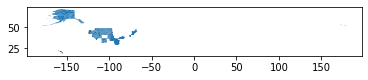

In [12]:
s = time.time()
z = pandas.read_csv(output_dir+'block_group_with_district_1_6.csv', index_col='GEOID')
bg_file_list = [shapefiledir+'BG/'+x for x in os.listdir(shapefiledir+'BG/') if ((x[-4:] == '.shp'))]
bg_gdf = geopandas.GeoDataFrame()
for i in range(0, len(bg_file_list)):
    if (debug >= 1):
        if ((np.mod(i,10) == 0) | (i == len(bg_file_list)-1)):
            print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(bg_file_list)))
    bg_gdf_i = geopandas.read_file(bg_file_list[i])
    bg_gdf = pandas.concat((bg_gdf, bg_gdf_i), axis=0, sort=False)
e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


s = time.time()
print('converting block group identifiers to numeric...')
bg_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(bg_gdf['STATEFP'], errors='coerce')
bg_gdf.loc[:, 'COUNTYFP'] = pandas.to_numeric(bg_gdf['COUNTYFP'], errors='coerce')
bg_gdf.loc[:, 'TRACTCE'] = pandas.to_numeric(bg_gdf['TRACTCE'].apply(lambda x: str(x)[0:4]+'.'+str(x)[4:]), errors='coerce')
bg_gdf.loc[:, 'BLKGRPCE'] = pandas.to_numeric(bg_gdf['BLKGRPCE'], errors='coerce')


print('assigning GEOID as index...')
bg_gdf.loc[:, 'GEOID'] = bg_gdf['GEOID'].apply(lambda x: '15000US'+str(x))#
bg_gdf = bg_gdf.set_index('GEOID')

geopandas.GeoDataFrame(data=z.join(bg_gdf.geometry, how='left'), crs=bg_gdf.crs, geometry='geometry').plot()

e = time.time()
print('done in {0:,.1f} seconds'.format(e-s))


## Examine overlapping districts

### LOUISIANA

#### Examine

#### Which districts overlap?

In [13]:
# # xlimits = (-91.31833504999999, -90.59215794999997)
# # ylimits = (30.698718250000002, 30.95965475)


# #xlimits = (-92.14, -91.95)
# #ylimits = (30.4, 30.65)

# # 2 vs 6 BOTH CLUSTERS
# # xlimits = (-91.26,-91.115)
# # ylimits = (30.36,30.54)

# # xlimits = (-91.27377884999999, -90.76261214999998)
# # ylimits = (29.98451145, 30.30134555)

# # xlimits =  (-91.06, -90.77)
# # ylimits = (30.08, 30.26)

# # xlimits =  (-90.932, -90.9)
# # ylimits = (30.22, 30.25)

# # xlimits = (-92.18227969999998, -92.04685429999999)
# # ylimits = (30.292847650000002, 30.424173350000004)

# xlimits = (-90.88, -90.7)
# ylimits = (30.73, 30.94)



# auto_limits = False
# label_tracts = False
# show_water = True
# show_roads = 'IUSCOM'# IUSCOM
# label_roads = True

# this_state = 'LA'
# test_this_bitmask = 'x000011'

# figbasesize = 100
# #center_coords = [np.round(np.mean(xlimits[0], xlimits[1]),2), np.round(np.mean(ylimits[0], ylimits[1]),2)]
# #aspect_ratio = '{0:.1f}:{1:.1f}'.format((xlimits[1]-xlimits[0]),(ylimits[1]-ylimits[0]))
# #print(center_coords)
# #print(aspect_ratio)
# print('Center coordinates: {1:.3f}, {0:.3f}'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))
# print('Aspect ratio: {0:}:{1:}'.format((xlimits[1]-xlimits[0])*figbasesize, (ylimits[1]-ylimits[0])*figbasesize))

# print('http://maps.google.com/maps?q={1:.3f},{0:.3f}&t=k'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))


In [14]:
# s = time.time()

# fig, ax = plt.subplots(1,1, figsize=(15,15))

# # # # # # cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red', alpha=0.5)
# # # cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green', alpha=0.5)
# # #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange', alpha=0.5)
# # cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='cyan', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 5)].plot(ax=ax, color='yellow', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 6)].plot(ax=ax, color='brown', alpha=0.5)

# # # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['COUNTY_NAME'] == 'Washington County')
# # ].plot(ax=ax, color='none', edgecolor='white', linewidth=0.5)|


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# #].plot(ax=ax, color='purple', edgecolor='none', alpha=0.4)#edgecolor='purple', linewidth=4)
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
#     & ((assembler_gdf['INTPTLON'] >= xlimits[0]) & (assembler_gdf['INTPTLON'] <= xlimits[1]))
#     & ((assembler_gdf['INTPTLAT'] >= ylimits[0]) & (assembler_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     b.append(ix)
#     if (label_tracts):
#         annotator = ix[-6:]
#         plt.annotate(annotator, 
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                          (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
#                    )

# # show_these_places = ['Springfield', 'Lebanon', 'St Catharine', 'Texas']
# # place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )

# if (show_water):
#     print('plotting water...')
#     water_gdf.plot(ax=ax, color='blue')


# print('plotting roads {0:}...'.format(show_roads))
# for i in range(0, len(show_roads)):
#     if (show_roads[i] == 'I'):
#         lw = 5
#         theroadcolor = 'black'
#     elif (show_roads[i] == 'U'):
#         lw = 1.5
#         theroadcolor = 'black'
#     elif (show_roads[i] == 'S'):
#         lw = 1
#         theroadcolor = 'red'
#     else:
#         lw = 0.5
#         theroadcolor = 'black'
#     roads_gdf[roads_gdf['RTTYP'] == show_roads[i]].plot(ax=ax, color=theroadcolor, linewidth=lw) 

# if (label_roads == True):
#     print('labeling roads...')
#     for ix, thisrow in roads_gdf[
#         ( (roads_gdf.geometry.centroid.x >= xlimits[0]) & (roads_gdf.geometry.centroid.x <= xlimits[1]) )
#         & ( (roads_gdf.geometry.centroid.y >= ylimits[0]) & (roads_gdf.geometry.centroid.y <= ylimits[1]) 
#           & (roads_gdf['FULLNAME'].notnull())
#           )
#     ].iterrows():
#         if ('State Rte' in str(thisrow['FULLNAME'])):        
#             annotator = thisrow['FULLNAME'][10:]
#             lesize = 16
# #         else:
# #             annotator = thisrow['FULLNAME']
# #             lesize = 10
#             plt.annotate(annotator, 
#                          (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y),
#                          (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y),
#                          color='black', backgroundcolor='white', fontsize=lesize*scale, ha='center'
#                         )


# if (not(auto_limits)):
#     plt.xlim(xlimits)
#     plt.ylim(ylimits)
# else:
#     xlimits = plt.xlim()
#     ylimits = plt.ylim()
#     print(xlimits)
#     print(ylimits)

# plt.xticks(fontsize=18*scale)
# plt.yticks(fontsize=18*scale)

# plt.title('1 = red, 2 = green, 3 = orange, 4 = cyan, 5 = yellow, 6 = brown', fontsize=18*scale)
# #plt.title('BG {0:}'.format('15000US220050303001'), fontsize=18*scale)
# plt.show()

# e = time.time()
# print('\n')
# print(e-s)





# # 15000US220050303001
# # -91.25, -91.04
# # 29.98, 30.09
# # Block Group 15000US220070501003 intersects district 2 with percent area 33.1%
# # Block Group 15000US220070501003 intersects district 6 with percent area 66.9%
# # Length of block group road network in district 2: 74,111 meters
# # Length of block group road network in district 6: 68,924 meters



# # 15000US220919511003
# # -90.86, -90.72
# # 30.77, 30.94
# # Block Group 15000US220919511003 intersects district 5 with percent area 57.6%
# # Block Group 15000US220919511003 intersects district 6 with percent area 42.4%
# # Length of block group road network in district 5: 82,398 meters
# # Length of block group road network in district 6: 86,450 meters
    
    
# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1)
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# # ][
# #     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population']
# # ].sort_index()

# b = sorted(b)

# # FURTHER INVESTIGATE 15000US220919511003

# for i in range(0,len(b)):
#     print(b[i])


#### Find relative overlaps of districts in this block group

In [15]:
# this_block_group = '15000US220919511003'

# print('finding geometries...')
# blogeo = assembler_gdf[assembler_gdf.index == this_block_group].to_crs(equal_area_crs).geometry.values[0]
# cd6geo = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 5)].to_crs(equal_area_crs).geometry.values[0]
# cd6intgeo = blogeo.intersection(cd6geo)

# cd5geo = cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 6)].to_crs(equal_area_crs).geometry.values[0]
# cd5intgeo = blogeo.intersection(cd5geo)

# print('Block Group {0:} intersects district {1:.0f} with percent area {2:.1%}'.format(this_block_group, 5, cd5intgeo.area/blogeo.area))
# print('Block Group {0:} intersects district {1:.0f} with percent area {2:.1%}'.format(this_block_group, 6, cd6intgeo.area/blogeo.area))
# #print(cd2intgeo.area/blogeo.area)

#### Find length of road network in each district in this block group

In [16]:
# print('finding roads in this block group...')
# cnt = 0
# roads_included_list = []
# for ix, thisrow in roads_gdf.to_crs(equal_area_crs).iterrows():
#     if ((np.mod(cnt,50000) == 0) | (cnt == len(roads_gdf)-1)):
#         print('\tProcessing road {0:,.0f} of {1:,.0f}...'.format(cnt+1, len(roads_gdf)))
#     cnt = cnt + 1
#     if (thisrow.geometry.intersects(blogeo)):
#         roads_included_list.append(thisrow.geometry.intersection(blogeo))
# print('Got all roads...')

# cd5roadsgeolist = []
# cd5roadlength = 0

# cd6roadsgeolist = []
# cd6roadlength = 0

# for x in roads_included_list:
#     if x.intersects(cd5intgeo):
#         cd5roadsgeolist.append(x.intersection(cd5intgeo))        
#     if x.intersects(cd6intgeo):
#         cd6roadsgeolist.append(x.intersection(cd6intgeo))
# print()
# print('Length of block group road network in district {0:.0f}: {1:,.0f} meters'.format(5,np.sum([x.length for x in cd5roadsgeolist])))
# print('Length of block group road network in district {0:.0f}: {1:,.0f} meters'.format(6,np.sum([x.length for x in cd6roadsgeolist])))





In [17]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'LA')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)


# # 1 and 2 (x110000):  38
# # 1 and 5 (x100010):   5
# # 1 and 6 (x100001):   9
# # 2 and 6 (x010001):  44
# # 3 and 4 (x001100):   3
# # 3 and 5 (x001010):   2
# # 4 and 5 (x000110):  11
# # 5 and 6 (x000011):   9


#### Get water areas, places, roads

In [18]:
# s = time.time()

# this_state = 'LA'
# this_state_number = 22
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

### KENTUCKY

#### Examine

In [19]:
# # ALL TOGETHER
# xlimits = [-84.4,-84.2]
# ylimits = [38.3,38.5]

# figbasesize = 20
# #center_coords = [np.round(np.mean(xlimits[0], xlimits[1]),2), np.round(np.mean(ylimits[0], ylimits[1]),2)]
# #aspect_ratio = '{0:.1f}:{1:.1f}'.format((xlimits[1]-xlimits[0]),(ylimits[1]-ylimits[0]))
# #print(center_coords)
# #print(aspect_ratio)
# print('Center coordinates: {0:.2f}, {1:.2f}'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))
# print('Aspect ratio: {0:}:{1:}'.format((xlimits[1]-xlimits[0])*figbasesize, (ylimits[1]-ylimits[0])*figbasesize))


In [20]:
# this_state = 'KY'

# test_this_bitmask = 'x000101'

# fig, ax = plt.subplots(1,1,figsize=(10*scale, 14*scale))


# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red', alpha=0.5)
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green', alpha=0.5)
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='cyan', alpha=0.5)
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 5)].plot(ax=ax, color='yellow', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 6)].plot(ax=ax, color='brown', alpha=0.5)

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['COUNTY_NAME'] == 'Washington County')
# # ].plot(ax=ax, color='none', edgecolor='white', linewidth=0.5)


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=5)


# #####  add labels for block groups with overlap
# b = []
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# ].iterrows():
#     b.append(ix)
# #     annotator = ix[-6:]
# #     plt.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                )

# # show_these_places = ['Springfield', 'Lebanon', 'St Catharine', 'Texas']
# # place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )

    
# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=2) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=1.5)
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[roads_gdf['RTTYP'].apply(lambda x: x not in ['I', 'U', 'S'])].plot(ax=ax, color='black', linewidth=0.5)

# if (not(auto_limits)):
#     plt.xlim(xlimits)
#     plt.ylim(ylimits)


# plt.title('1 = red, 2 = green, 3 = orange, 4 = cyan, 5 = yellow, 6 = brown', fontsize=18*scale)
# plt.show()

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1)
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# # ][
# #     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population']
# # ].sort_index()

# b = sorted(b)
# for i in range(0,len(b)):
#     print("'"+b[i]+"'")
    




#### Which districts overlap?

In [21]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'KY')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # 1 and 2 (x110000):   1
# # 2 and 4 (x010100):   5
# # 2 and 6 (x010001):   5
# # 3 and 4 (x001100):   9
# # 4 and 5 (x000110):   5
# # 4 and 6 (x000101):   5


#### Get water areas, places, roads

In [22]:
# s = time.time()

# this_state = 'KY'
# this_state_number = 21
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

### OREGON

#### Examine

In [23]:
# # ALL AREAS
# # xlimits = [-122.78,-122.4]
# # ylimits = [45.28,45.5]

# xlimits = [-122.6,-122.48]
# ylimits = [45.28,45.42]

# figbasesize = 80
# print('Center coordinates: {0:.2f}, {1:.2f}'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))
# print('Aspect ratio: {0:}:{1:}'.format((xlimits[1]-xlimits[0])*figbasesize, (ylimits[1]-ylimits[0])*figbasesize))


In [24]:
# this_state = 'OR'

# test_this_bitmask = 'x00101'

# fig, ax = plt.subplots(1,1,figsize=(9.5*scale, 11.2*scale))


# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red', alpha=0.5)
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange', alpha=0.5)
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='cyan', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 5)].plot(ax=ax, color='yellow', alpha=0.5)

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['COUNTY_NAME'] == 'Clackamas County')
# # ].plot(ax=ax, color='none', edgecolor='brown', linewidth=0.5)


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=5)


# #####  add labels for block groups with overlap
# b = "'"
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# ].iterrows():
#     b += "'"+ix+"',"
#     annotator = ix[-6:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
#                )

# # show_these_places = ['Limestone', 'Collinsville']
# # #place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )

    
# print('plotting water...')
# water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=2) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=1.5)
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[roads_gdf['RTTYP'].apply(lambda x: x not in ['I', 'U', 'S'])].plot(ax=ax, color='black', linewidth=0.5)

# plt.xlim(xlimits)
# plt.ylim(ylimits)


# plt.title('1 = red, 2 = green, 3 = orange, 4 = cyan, 5 = yellow', fontsize=18*scale)
# plt.show()

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1)
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# # ][
# #     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population']
# # ].sort_index()


# print(b)


#### Which districts overlap?

In [25]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'OR')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # 1 and 3 and 5 (x10101):   1
# # 1 and 3 (x10100):   13
# # 2 and 4 (x01010):    4
# # 3 and 5 (x00101):   24
# # 4 and 5: (x00011)    1


#### Get water areas, places, roads

In [26]:
# s = time.time()

# this_state = 'OR'
# this_state_number = 41
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

### OKLAHOMA

#### Examine

In [27]:
# # ALL TOGETHER
# xlimits = [-97.36,-97.2]
# ylimits = [35.4,35.55]

# figbasesize = 60
# #center_coords = [np.round(np.mean(xlimits[0], xlimits[1]),2), np.round(np.mean(ylimits[0], ylimits[1]),2)]
# #aspect_ratio = '{0:.1f}:{1:.1f}'.format((xlimits[1]-xlimits[0]),(ylimits[1]-ylimits[0]))
# #print(center_coords)
# #print(aspect_ratio)
# print('Center coordinates: {0:.2f}, {1:.2f}'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))
# print('Aspect ratio: {0:}:{1:}'.format((xlimits[1]-xlimits[0])*figbasesize, (ylimits[1]-ylimits[0])*figbasesize))


In [28]:
# this_state = 'OK'

# test_this_bitmask = 'x00011'

# fig, ax = plt.subplots(1,1,figsize=(9.5*scale, 9*scale))


# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red', alpha=0.5)
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green', alpha=0.5)
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='cyan', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 5)].plot(ax=ax, color='yellow', alpha=0.5)

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['COUNTY_NAME'] == 'Rogers County')
# # ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=5)


# #####  add labels for block groups with overlap
# b = "'"
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# ].iterrows():
#     b += "'"+ix+"',"
#     #print(ix)
# #     annotator = ix[-6:]
# #     plt.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )

# # show_these_places = ['Limestone', 'Collinsville']
# # #place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )

    
# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=2) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=1.5)
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[roads_gdf['RTTYP'].apply(lambda x: x not in ['I', 'U', 'S'])].plot(ax=ax, color='black', linewidth=0.5)

# plt.xlim(xlimits)
# plt.ylim(ylimits)


# plt.title('1 = red, 2 = green, 3 = orange, 4 = cyan, 5 = yellow', fontsize=18*scale)
# plt.show()

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# ][
#     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population']
# ].sort_index()

# print(b)


#### Which districts overlap?

In [29]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'OK')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)

# # 1 and 2 (x11000)    7
# # 1 and 3 (x10100)    4
# # 3 and 4 (x00110)    2
# # 4 and 5 (x00011)    7



#### Get water areas, places, roads

In [30]:
# s = time.time()

# this_state = 'OK'
# this_state_number = 40
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

### CONNECTICUT

### Examination

In [31]:
# # ALL TOGETHER
# xlimits = [-73.2,-73.05]
# ylimits = [41.775, 41.85]

# # xlimits = [-112.4,-111.1]
# # ylimits = [39.2, 40]

# figbasesize = 64
# #center_coords = [np.round(np.mean(xlimits[0], xlimits[1]),2), np.round(np.mean(ylimits[0], ylimits[1]),2)]
# #aspect_ratio = '{0:.1f}:{1:.1f}'.format((xlimits[1]-xlimits[0]),(ylimits[1]-ylimits[0]))
# #print(center_coords)
# #print(aspect_ratio)
# print('Center coordinates: {0:.2f}, {1:.2f}'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))
# print('Aspect ratio: {0:}:{1:}'.format((xlimits[1]-xlimits[0])*figbasesize, (ylimits[1]-ylimits[0])*figbasesize))


In [32]:
# this_state = 'CT'

# test_this_bitmask = 'x10001'

# fig, ax = plt.subplots(1,1,figsize=(12*scale, 6*scale))


# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red')
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green')
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange')
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='cyan')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 5)].plot(ax=ax, color='yellow')

# # # assembler_gdf[
# # #     (assembler_gdf['STUSAB'] == this_state) 
# # #     & (assembler_gdf['COUNTY_NAME'] == 'Salt Lake County')
# # # ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)


# # #####  add labels for block groups with overlap
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1) 
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# # ].iterrows():
# #     print(ix)
# #     annotator = ix[-6:]
# #     plt.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )

# # show_these_places = ['Salt Lake City', 'Summit Park', 'Wanship']
# # place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
    
# print('plotting water...')
# water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=2) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=1.5)
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[roads_gdf['RTTYP'].apply(lambda x: x not in ['I', 'U', 'S'])].plot(ax=ax, color='black', linewidth=0.5)

# plt.xlim(xlimits)
# plt.ylim(ylimits)


# plt.title('1 = red, 2 = green, 3 = orange, 4 = cyan, 5 = yellow', fontsize=18*scale)
# plt.show()

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# ][
#     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population']
# ].sort_index()





#### Which districts overlap?

In [33]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'CT')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size()
# # 1 and 2 (x11000):    3
# # 1 and 3 (x10100):    4
# # 1 and 5 (x10001):    5
# # 3 and 4 (x00110):    4
# # 3 and 5 (x00101):    9
# # 4 and 5 (x00011):    2

#### Get water areas, places, roads

In [34]:
# s = time.time()

# this_state = 'CT'
# this_state_number = 9
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

### UTAH

In [35]:
# # ALL TOGETHER
# xlimits = [-112.1,-111.8]
# ylimits = [40.6, 40.8]

# # xlimits = [-112.4,-111.1]
# # ylimits = [39.2, 40]

# figbasesize = 40
# #center_coords = [np.round(np.mean(xlimits[0], xlimits[1]),2), np.round(np.mean(ylimits[0], ylimits[1]),2)]
# #aspect_ratio = '{0:.1f}:{1:.1f}'.format((xlimits[1]-xlimits[0]),(ylimits[1]-ylimits[0]))
# #print(center_coords)
# #print(aspect_ratio)
# print('Center coordinates: {0:.2f}, {1:.2f}'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))
# print('Aspect ratio: {0:}:{1:}'.format((xlimits[1]-xlimits[0])*figbasesize, (ylimits[1]-ylimits[0])*figbasesize))


In [36]:
# this_state = 'UT'

# test_this_bitmask = 'x0101'

# fig, ax = plt.subplots(1,1,figsize=(12*scale, 8*scale))


# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green')
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='cyan')

# # # assembler_gdf[
# # #     (assembler_gdf['STUSAB'] == this_state) 
# # #     & (assembler_gdf['COUNTY_NAME'] == 'Salt Lake County')
# # # ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)


# # #####  add labels for block groups with overlap
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1) 
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# # ].iterrows():
# #     print(ix)
# #     annotator = ix[-6:]
# #     plt.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )

# # show_these_places = ['Salt Lake City', 'Summit Park', 'Wanship']
# # place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
    
# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=2) 
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=1.5)
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[roads_gdf['RTTYP'].apply(lambda x: x not in ['I', 'U', 'S'])].plot(ax=ax, color='black', linewidth=0.5)

# plt.xlim(xlimits)
# plt.ylim(ylimits)


# plt.title('1 = red, 2 = green, 3 = orange, 4 = cyan', fontsize=18*scale)
# plt.show()

# assembler_gdf[
#     #(assembler_gdf.index.map(lambda x: x[-6:])) 
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# ][
#     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population']
# ].sort_index()

# #15000US490351139071


#### Which districts overlap?

In [37]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'UT')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size()

# # 2 and 3 and 4 (x0111): 1
# # 1 and 2 (x1100):  8
# # 2 and 4 (x0101): 15
# # 3 and 4 (x0011): 11

#### Get water areas, places, roads

In [38]:
# s = time.time()

# this_state = 'UT'
# this_state_number = 49
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

### NEVADA

#### Examination

In [39]:
# xlimits = [-115.32,-115.26]
# ylimits = [36.15,36.2]
# figbasesize = 96
# #center_coords = [np.round(np.mean(xlimits[0], xlimits[1]),2), np.round(np.mean(ylimits[0], ylimits[1]),2)]
# #aspect_ratio = '{0:.1f}:{1:.1f}'.format((xlimits[1]-xlimits[0]),(ylimits[1]-ylimits[0]))
# #print(center_coords)
# #print(aspect_ratio)
# print('Center coordinates: {0:.2f}, {1:.2f}'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))
# print('Aspect ratio: {0:}:{1:}'.format((xlimits[1]-xlimits[0])*figbasesize, (ylimits[1]-ylimits[0])*figbasesize))


In [40]:
# this_state = 'NV'

# test_this_bitmask = 'x0011'

# fig, ax = plt.subplots(1,1,figsize=(12*scale, 12*scale))

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
# ].plot(ax=ax, column='block_based_district')


# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='none', edgecolor='red')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='none', edgecolor='green')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='none', edgecolor='orange')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='none', edgecolor='cyan')

# for ix, thisrow in cd_gdf[cd_gdf['STUSAB'] == 'this_state'].iterrows():
#     annotator = thisrow['CD116FP']
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=20*scale, ha='center'
#                 )

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['COUNTY_NAME'] == 'Clark County')
# # ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)


# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state)
# #     & (assembler_gdf['block_based_district'] == -1)
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# # ].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)



# # #####  add labels for block groups with overlap
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1) 
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# # ].iterrows():
# #     print(ix)
# #     annotator = ix[-6:]
# #     plt.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )

# # show_these_places = ['Las Vegas', 'Corn Creek']
# # place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
    
# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# # # # print('plotting roads...')
# # roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='blue', linewidth=2) 
# # roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=1.5)
# # roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=1)
# # roads_gdf[roads_gdf['RTTYP'].apply(lambda x: x not in ['I', 'U', 'S'])].plot(ax=ax, color='black', linewidth=0.5)

# # plt.xlim(xlimits)
# # plt.ylim(ylimits)


# #plt.title('1 = red, 2 = green, 3 = orange, 4 = cyan', fontsize=18*scale)
# plt.show()

# # assembler_gdf[
# #     #(assembler_gdf.index.map(lambda x: x[-6:])) 
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1)
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# # ][
# #     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'total_population']
# # ].sort_index()


#### Which districts overlap?

In [41]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'NV')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size()

# # 1 and 3 and 4 (x1011): 1
# # 1 and 3 (x1010): 11
# # 1 and 4 (x1001):  8
# # 2 and 4 (x0101):  3
# # 3 AND 4 (x0011):  4

#### Get water areas, places, roads

In [42]:
# s = time.time()

# this_state = 'NV'
# this_state_number = 32
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

### MISSISSIPPI

#### Examination

In [43]:
# xlimits = [-90.225,-90.15]
# ylimits = [32.26, 32.33]
# figbasesize = 100
# #center_coords = [np.round(np.mean(xlimits[0], xlimits[1]),2), np.round(np.mean(ylimits[0], ylimits[1]),2)]
# #aspect_ratio = '{0:.1f}:{1:.1f}'.format((xlimits[1]-xlimits[0]),(ylimits[1]-ylimits[0]))
# #print(center_coords)
# #print(aspect_ratio)
# print('Center coordinates: {0:.2f}, {1:.2f}'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))
# print('Aspect ratio: {0:}:{1:}'.format((xlimits[1]-xlimits[0])*figbasesize, (ylimits[1]-ylimits[0])*figbasesize))


In [44]:
# # print('getting from again-backup...')
# # assembler_gdf = assembler_gdf_bk2
# this_state = 'MS'

# test_this_bitmask = 'x0110'

# fig, ax = plt.subplots(1,1,figsize=(14.8*scale, 14*scale))

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
# ].plot(ax=ax, column='block_based_district', edgecolor='none')

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='none', edgecolor='red', linewidth=3)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='none', edgecolor='green', linewidth=3)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='none', edgecolor='orange', linewidth=3)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='none', edgecolor='cyan', linewidth=3)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['nDistricts'] > 1)
# ].plot(ax=ax, color='none', edgecolor='black', linewidth=2)


# #####  add labels for block-based districts
# for ix, thisrow in cd_gdf[
#     (cd_gdf['STUSAB'] == this_state) 
# ].iterrows():
#     annotator = thisrow['CD116FP']
#     plt.annotate(annotator, 
#                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                     (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
#                 )

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['COUNTY_NAME'] == 'Madison County')
# # ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1) 
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# # ].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)


# # # # add labels for those block groups
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1) 
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# # ].iterrows():
# #     print(ix)
# #     annotator = ix[-6:]
# #     plt.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )

# # # show_these_places = ['Jackson', 'Tougaloo']
# # # place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# # #     annotator = thisrow['NAME'].upper()
# # #     plt.annotate(annotator, 
# # #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# # #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# # #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# # #                 )
    
    
# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# # # print('plotting roads...')
# # roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='blue', linewidth=2) 
# # # roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=1.5)
# # # roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=1)
# # # roads_gdf[roads_gdf['RTTYP'].apply(lambda x: x not in ['I', 'U', 'S'])].plot(ax=ax, color='black', linewidth=0.5)

# # # plt.xlim(xlimits)
# # # plt.ylim(ylimits)


# #plt.title('1 = red, 2 = green, 3 = orange, 4 = cyan', fontsize=18*scale)
# plt.show()

# # assembler_gdf[
# #     #(assembler_gdf.index.map(lambda x: x[-6:])) 
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1)
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# # ][
# #     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'area_km2', 'total_population']
# # ].sort_index()


#### Which districts overlap?

In [45]:


# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'MS')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size()

# # 1 and 3:  5
# # 2 and 3:  16
# # 3 AND 4:  6


#### Get water areas, places, roads

In [46]:
# s = time.time()

# this_state = 'MS'
# this_state_number = 28
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

#### Calculate areas

In [47]:
# s = time.time()
# # print('getting from again-backup...')
# # assembler_gdf = assembler_gdf_bk2

# print('calculating block group areas...')
# equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
# assembler_gdf = assembler_gdf.assign(area_km2 = assembler_gdf.to_crs(equal_area_crs).geometry.area/1000000)

# print('backing up...')
# assembler_gdf_bk3 = assembler_gdf
# e = time.time()
# g = g + (e-s)

# print('found areas for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))


### KANSAS

#### Examination

In [48]:
# xlimits = [-97,-96.2]
# ylimits = [39.4, 40.1]
# figbasesize = 24
# #center_coords = [np.round(np.mean(xlimits[0], xlimits[1]),2), np.round(np.mean(ylimits[0], ylimits[1]),2)]
# #aspect_ratio = '{0:.1f}:{1:.1f}'.format((xlimits[1]-xlimits[0]),(ylimits[1]-ylimits[0]))
# #print(center_coords)
# #print(aspect_ratio)
# print('Center coordinates: {0:.2f}, {1:.2f}'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))
# print('Aspect ratio: {0:}:{1:}'.format((xlimits[1]-xlimits[0])*figbasesize, (ylimits[1]-ylimits[0])*figbasesize))


In [49]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk3
# this_state = 'KS'

# test_this_bitmask = 'x1100'

# fig, ax = plt.subplots(1,1,figsize=(19*scale, 17*scale))

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green', alpha=0.5)
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange', alpha=0.5)
# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='cyan', alpha=0.5)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['COUNTY_NAME'] == 'Marshall County')
# ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)


# # # add labels for those block groups
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# #    & (assembler_gdf['COUNTY_NAME'] == 'Bernalillo County')
# ].iterrows():
#     annotator = ix[-4:]
#     plt.annotate(annotator, 
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
#                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
#                 )
    
# # # # print('plotting places...')

# # show_these_places = ['Marysville', 'Frankfort', 'Blue Rapids']
# # place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
    
# #print('plotting water...')
# #water_gdf.plot(ax=ax, color='blue')

# # print('plotting roads...')
# roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='blue', linewidth=2)
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=1.5)
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[roads_gdf['RTTYP'].apply(lambda x: x not in ['I', 'U', 'S'])].plot(ax=ax, color='black', linewidth=0.5)



# plt.xlim(xlimits)
# plt.ylim(ylimits)


# plt.title('1 = red, 2 = green, 3 = orange, 4 = cyan', fontsize=18*scale)
# plt.show()

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# #    & (assembler_gdf['COUNTY_NAME'] == 'Valencia County')
# ][
#     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'area_km2', 'total_population']
# ].sort_values('area_km2', ascending=False)



In [50]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'KS')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size()

# # 1 and 2:  5
# # 1 and 4:  1
# # 2 AND 3:  4


#### Get water areas, places, roads

In [51]:
# s = time.time()

# this_state = 'KS'
# this_state_number = 20
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

#### Calculate areas of tracts

In [52]:
# s = time.time()
# # print('getting from again-backup...')
# # assembler_gdf = assembler_gdf_bk2

# print('calculating block group areas...')
# equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
# assembler_gdf = assembler_gdf.assign(area_km2 = assembler_gdf.to_crs(equal_area_crs).geometry.area/1000000)

# print('backing up...')
# assembler_gdf_bk3 = assembler_gdf
# e = time.time()
# g = g + (e-s)

# print('found areas for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))


#### Overview

In [53]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk3

# this_state = 'KS'
# fig, ax = plt.subplots(1,1,figsize=(12*scale,8*scale))

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='cyan')

# # assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] == 1)].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)
# # assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] > 1)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] != -1)].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)
# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == -1)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# #water_gdf.plot(ax=ax, color='blue')
# plt.show()

# #assembler_gdf[assembler_gdf['block_based_district'] == -1]


### ARKANSAS

#### Examination

In [54]:
# xlimits = [-93.3,-93.08]
# ylimits = [35.95,36.1]
# figbasesize = 48
# #center_coords = [np.round(np.mean(xlimits[0], xlimits[1]),2), np.round(np.mean(ylimits[0], ylimits[1]),2)]
# #aspect_ratio = '{0:.1f}:{1:.1f}'.format((xlimits[1]-xlimits[0]),(ylimits[1]-ylimits[0]))
# #print(center_coords)
# #print(aspect_ratio)
# print('Center coordinates: {0:.2f}, {1:.2f}'.format((xlimits[0]+xlimits[1])/2, (ylimits[0]+ylimits[1])/2))
# print('Aspect ratio: {0:}:{1:}'.format((xlimits[1]-xlimits[0])*figbasesize, (ylimits[1]-ylimits[0])*figbasesize))


In [55]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk2
# this_state = 'AR'

# test_this_bitmask = 'x0011'

# fig, ax = plt.subplots(1,1,figsize=(10.5*scale, 7*scale))

# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red', alpha=0.5)
# # cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='cyan', alpha=0.5)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['COUNTY_NAME'] == 'Newton County')
# ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
# #    & (assembler_gdf['COUNTY_NAME'] == 'McKinley County')
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=3)


# # # # add labels for those block groups
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1) 
# #     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask) 
# # #    & (assembler_gdf['COUNTY_NAME'] == 'Bernalillo County')
# # ].iterrows():
# #     annotator = ix[-4:]
# #     plt.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
# # # # print('plotting places...')

# show_these_places = ['Jasper']
# #place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
    
# print('plotting water...')
# water_gdf.plot(ax=ax, color='blue')

# # print('plotting roads...')
# # roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='blue', linewidth=2)
# # roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=1.5)
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[roads_gdf['RTTYP'].apply(lambda x: x not in ['I', 'U', 'S'])].plot(ax=ax, color='black', linewidth=0.5)

# # 3 AND 4 LEFT SIDE
# #xlimits = [-94.6,-94]
# #ylimits = [34.9,35.8]

# # MIDLAND/HACKETT
# # xlimits = [-94.5,-94.1]
# # ylimits = [34.95,35.2]

# # ALMA/RUDY
# # xlimits = [-94.31,-94.14]
# # ylimits = [35.45,35.57]

# plt.xlim(xlimits)
# plt.ylim(ylimits)


# plt.title('1 = red, 2 = green, 3 = orange, 4 = cyan', fontsize=18*scale)
# plt.show()

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == test_this_bitmask)
# #    & (assembler_gdf['COUNTY_NAME'] == 'Valencia County')
# ][
#     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'area_km2', 'total_population']
# ].sort_values('area_km2', ascending=False)




#### Which districts overlap?

In [56]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'AR')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size()

# # 3 and 4: 24
# # 1 and 4:  4
# # 1 and 3:  2


#### Get water areas, places, and roads

In [57]:
# s = time.time()

# this_state = 'AR'
# this_state_number = 5
# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

#### Calculate areas of block groups

In [58]:
# s = time.time()
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk2

# print('calculating block group areas...')
# equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
# assembler_gdf = assembler_gdf.assign(area_km2 = assembler_gdf.to_crs(equal_area_crs).geometry.area/1000000)

# print('backing up...')
# assembler_gdf_bk3 = assembler_gdf
# e = time.time()
# g = g + (e-s)

# print('found areas for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))


#### Overview

In [59]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk3

# this_state = 'AR'
# fig, ax = plt.subplots(1,1,figsize=(12*scale,8*scale))

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 4)].plot(ax=ax, color='cyan')

# # assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] == 1)].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)
# # assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] > 1)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] != -1)].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)
# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == -1)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# #water_gdf.plot(ax=ax, color='blue')
# plt.show()

# #assembler_gdf[assembler_gdf['block_based_district'] == -1]


### NEW MEXICO

#### Get water areas, places, and roads

In [60]:
# s = time.time()

# this_state = 'NM'
# #print(state_codes_df)

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]
# this_state_number = 35

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())
# s = time.time()

# this_state = 'NM'
# #print(state_codes_df)

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]
# this_state_number = 35

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(place_gdf), e-s))
# #place_gdf.head(1)

# s = time.time()

# this_state = 'NM'
# #print(state_codes_df)

# if (debug >= 1):
#     print('reading roads shapefiles in {0:}...'.format(this_state))

# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]
# this_state_number = 35

# roads_gdf = geopandas.GeoDataFrame()
# roads_file_list = [shapefiledir+'ROADS/'+x for x in os.listdir(shapefiledir+'ROADS/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(roads_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
#     roads_gdf_i = geopandas.read_file(roads_file_list[i])
    
#     roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)

# roads_gdf = roads_gdf.set_index('LINEARID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} roads in {1:,.1f} seconds!'.format(len(roads_gdf), e-s))

# #roads_gdf.head(1).T
# # Road Types: C = County, I = Interstate, M = Common name, O = Other, S = State hwy, U = US hwy

# #roads_file_list

#### Calculate areas of block groups

In [61]:
# s = time.time()
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk2

# print('calculating block group areas...')
# equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
# assembler_gdf = assembler_gdf.assign(area_km2 = assembler_gdf.to_crs(equal_area_crs).geometry.area/1000000)

# print('backing up...')
# assembler_gdf_bk3 = assembler_gdf
# e = time.time()
# g = g + (e-s)

# print('found areas for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))


#### How many overlap in each district?

In [62]:
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == 'NM')
#     & (assembler_gdf['block_based_district'] == -1)
# ].groupby('congressional_districts_bitmask').size().sort_index(ascending=False)



#### Overview

In [63]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk3

# this_state = 'NM'
# fig, ax = plt.subplots(1,1,figsize=(12*scale,8*scale))

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange')

# # assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] == 1)].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)
# # assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] > 1)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] != -1)].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)
# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == -1)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# #water_gdf.plot(ax=ax, color='blue')
# plt.show()

# #assembler_gdf[assembler_gdf['block_based_district'] == -1]


#### Examination

In [64]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk3
# this_state = 'NM'


# xlimits = [-104.2, -102.8]
# ylimits = [33.9,34.7]


# fig, ax = plt.subplots(1,1,figsize=(15*scale, 6*scale))

# #cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange', alpha=0.5)

# # assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['COUNTY_NAME'] == 'McKinley County')
# # ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
# #    & (assembler_gdf['COUNTY_NAME'] == 'McKinley County')
#     & (assembler_gdf['block_based_district'] == -1) 
#     & (assembler_gdf['congressional_districts_bitmask'] == 'x011') 
# ].plot(ax=ax, color='none', edgecolor='purple', linewidth=2)


# # # # add labels for those block groups
# # for ix, thisrow in assembler_gdf[
# #     (assembler_gdf['STUSAB'] == this_state) 
# #     & (assembler_gdf['block_based_district'] == -1) 
# #     & (assembler_gdf['congressional_districts_bitmask'] == 'x011') 
# # #    & (assembler_gdf['COUNTY_NAME'] == 'Bernalillo County')
# # ].iterrows():
# #     annotator = ix[-4:]
# #     plt.annotate(annotator, 
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                      (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='black', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
# # # print('plotting places...')

# show_these_places = ['Portales']
# #place_gdf[place_gdf['NAME'].isin(show_these_places)].plot(ax=ax, color='none', edgecolor='blue', linewidth=4)

# # for ix, thisrow in place_gdf[place_gdf['NAME'].isin(show_these_places)].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  (float(thisrow['INTPTLON']), float(thisrow['INTPTLAT'])),
# #                  color='blue', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
    
# # print('plotting water...')
# # water_gdf.plot(ax=ax, color='blue')

# print('plotting roads...')
# #roads_gdf[roads_gdf['RTTYP'] == 'I'].plot(ax=ax, color='black', linewidth=2)
# roads_gdf[roads_gdf['RTTYP'] == 'U'].plot(ax=ax, color='black', linewidth=1.5)
# roads_gdf[roads_gdf['RTTYP'] == 'S'].plot(ax=ax, color='black', linewidth=1)
# roads_gdf[roads_gdf['RTTYP'].apply(lambda x: x not in ['I', 'U', 'S'])].plot(ax=ax, color='black', linewidth=0.5)

# # # # 1 vs 2 ALL OVERLAPS
# # plt.xlim([-107.2, -106.1])
# # plt.ylim([34.6, 35.6])

# # # 1 vs 2 N BERNALILLO COUNTY
# # plt.xlim([-106.8, -106.3])
# # plt.ylim([34.8, 35.1])

# # # VALENCIA COUNTY
# # plt.xlim([-106.8, -106.4])
# # plt.ylim([34.6, 34.9])

# # 1 AND 3 ALL OVERLAPS
# plt.xlim([-107.2, -106])
# plt.ylim([34.8, 36])

# #1 AND 3
# # plt.xlim([-106.8, -106.4])
# # plt.ylim([35.1, 35.4])

# # # 1 AND 3
# # plt.xlim([-106.77, -106.65])
# # plt.ylim([35.15, 35.25])

# #1 AND 3
# # plt.xlim([-106.62, -106.32])
# # plt.ylim([35.2, 35.4])

# #1 AND 3
# # plt.xlim([-106.675, -106.575])
# # plt.ylim([35.2, 35.3])
# #plt.xlim([-106.65, -106.55])
# #plt.ylim([35.225, 35.325])
# # plt.xlim([-106.3, -106])
# # plt.ylim([35, 35.2])

# # 2 VS 3 WEST
# #plt.xlim([-109.1,-108.1])
# #plt.ylim([34,36])

# # plt.xlim([-108.95,-108.78])
# # plt.ylim([35.02,35.12])

# # 2 VS 3 EAST
# # plt.xlim(xlimits)
# # plt.ylim(ylimits)


# # CLOSE-UP OF PORTALES
# plt.xlim([-103.44, -103.29])
# plt.ylim([34.15,34.205])

# # print(np.round(np.mean([-108.95,-108.78]),2))
# # print(np.round(np.mean([35.02,35.12]),2))


# plt.title('1 = red, 2 = green, 3 = orange', fontsize=18*scale)
# plt.show()

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1)
#     & (assembler_gdf['congressional_districts_bitmask'] == 'x011')
# #    & (assembler_gdf['COUNTY_NAME'] == 'Valencia County')
# ][
#     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'area_km2', 'total_population']
# ].sort_values('area_km2', ascending=False)



#### Which block groups overlap which districts?

In [65]:
# this_state = 'NM'
# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['nDistricts'] > 1)
# ].groupby('congressional_districts_bitmask').size()

# # congressional_districts_bitmask
# # x011    14
# # x101    18
# # x110    13

# these_block_groups_list = assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state)
#     & (assembler_gdf['congressional_districts_bitmask'] == 'x101')
# ].index.tolist()
# print('ok')

# assembler_gdf[assembler_gdf['STUSAB'] == 'NM'].groupby('congressional_districts_bitmask').size()


### NEBRASKA

#### Get water areas

In [66]:
# s = time.time()

# this_state = 'NE'
# #print(state_codes_df)

# if (debug >= 1):
#     print('reading water shapefiles in {0:}...'.format(this_state))

# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]
# this_state_number = 31

# water_gdf = geopandas.GeoDataFrame()
# water_file_list = [shapefiledir+'AREAWATER/'+x for x in os.listdir(shapefiledir+'AREAWATER/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(water_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(water_file_list)))
#     water_gdf_i = geopandas.read_file(water_file_list[i])
#     #water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
#     water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0, sort=False)

# water_gdf = water_gdf.set_index('HYDROID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} bodies of water in {1:,.0f} seconds!'.format(len(water_gdf), e-s))
# #print(assembler_gdf.groupby(['STUSAB', 'block_based_district']).size())


#### Read places

In [67]:
# s = time.time()

# this_state = 'NE'
# #print(state_codes_df)

# if (debug >= 1):
#     print('reading place shapefiles in {0:}...'.format(this_state))

# #this_state_number = state_codes_df[state_codes_df['STUSAB'] == this_state.upper()].index.values[0]
# this_state_number = 31

# place_gdf = geopandas.GeoDataFrame()
# place_file_list = [shapefiledir+'PLACE/'+x for x in os.listdir(shapefiledir+'PLACE/') if ((x[-4:] == '.shp') and ('tl_2018_{0:02d}'.format(this_state_number) in x))]

# for i in range(0, len(place_file_list)):
#     if (debug >= 1):
#         if ((np.mod(i,10) == 0) | (i == len(water_file_list)-1)):
#             print('\tReading file {0:,.0f} of {1:,.0f}...'.format(i+1, len(place_file_list)))
#     place_gdf_i = geopandas.read_file(place_file_list[i])
    
#     place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0, sort=False)

# place_gdf = place_gdf.set_index('GEOID')
# e = time.time()
# g = g + (e-s)

# if (debug >= 1):
#     #print('Read {0:,.0f} bodies of water with area greater than or equal to {1:,.0f} km^2 in {2:,.0f} seconds!'.format(len(water_gdf), water_area_tol/(1000*1000), e-s))
#     print('Read {0:,.0f} places in {1:,.1f} seconds!'.format(len(water_gdf), e-s))
# #place_gdf.head(1)

In [68]:
#### Find which districts are overlapped between

#### Overview

In [69]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk2

# this_state = 'NM'
# fig, ax = plt.subplots(1,1,figsize=(12*scale,8*scale))

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green')
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange')

# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] == 1)].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)
# assembler_gdf[(assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['nDistricts'] > 1)].plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# #water_gdf.plot(ax=ax, color='blue')
# plt.show()

# #assembler_gdf[assembler_gdf['block_based_district'] == -1]



#### Calculating areas of block groups

In [70]:
# s = time.time()
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk2

# print('calculating block group areas...')
# equal_area_crs = {'init': 'epsg:2163'}  # An equal area projection: https://epsg.io/2163
# assembler_gdf = assembler_gdf.assign(area_km2 = assembler_gdf.to_crs(equal_area_crs).geometry.area/1000000)

# print('backing up...')
# assembler_gdf_bk3 = assembler_gdf
# e = time.time()
# g = g + (e-s)

# print('found areas for {0:,.0f} block groups in {1:} in {2:,.0f} minutes {3:,.0f} seconds!'.format(len(assembler_i_gdf), this_state, np.floor((e-s)/60), np.floor((e-s)%60)))


#### Examining

In [71]:
# print('getting from again-backup...')
# assembler_gdf = assembler_gdf_bk3
# this_state = 'NE'

# fig, ax = plt.subplots(1,1,figsize=(24*scale,24*scale))

# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 1)].plot(ax=ax, color='red', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 2)].plot(ax=ax, color='green', alpha=0.5)
# cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116FP'] == 3)].plot(ax=ax, color='orange', alpha=0.5)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] != -1)
#     & (assembler_gdf['COUNTY_NAME'] == 'Sarpy County')
# ].plot(ax=ax, color='none', edgecolor='yellow', linewidth=0.5)

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) & (assembler_gdf['block_based_district'] == -1)
# ].plot(ax=ax, color='none', edgecolor='black', linewidth=2)


# # # add labels for those block groups
# for ix, thisrow in assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1) 
#     #& (assembler_gdf.index.isin(['15000US310519778001','15000US310519778003']))
# #    & (assembler_gdf['total_population'] > 0)
# ].iterrows():
#     annotator = ix[-4:]
# #     annotator += '\n'
#     #annotator = thisrow['Geography Name'].replace(',',"\n")
#     #annotator = thisrow['block_based_district']
#     plt.annotate(annotator, 
#                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                  color='black', backgroundcolor='white', fontsize=12*scale, ha='center'
#                 )
    
# # print('plotting places...')

# # place_gdf.plot(ax=ax, color='none', edgecolor='purple', linewidth=2)
# #place_gdf[place_gdf['NAME'] == 'Omaha'].plot(ax=ax, color='none', edgecolor='purple', linewidth=4)

# # for ix, thisrow in place_gdf[
# #     place_gdf['NAME'].isin(['Bellevue', 'La Vista', 'Papillion', 'La Platte', 'Cullom', 'St. Columbans'])
# # ].iterrows():
# #     annotator = thisrow['NAME'].upper()
# #     plt.annotate(annotator, 
# #                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                  (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
# #                  color='purple', backgroundcolor='white', fontsize=14*scale, ha='center'
# #                 )
    
    
# print('plotting water...')
# water_gdf.plot(ax=ax, color='blue')

# # # SARPY COUNTY
# # plt.xlim([-96.4, -95.8])
# # ##plt.xlim([-96.1, -96.4])
# # plt.ylim([41, 41.3])
    
# # OMAHA AREA OVERLAPS
# plt.xlim([-96.025, -95.9])
# plt.ylim([41.075,41.2])

# plt.title('1 = red, 2 = green, 3 = orange', fontsize=18*scale)
# plt.show()

# assembler_gdf[
#     (assembler_gdf['STUSAB'] == this_state) 
#     & (assembler_gdf['block_based_district'] == -1)
# ][
#     ['STATE_NAME', 'COUNTY_NAME', 'TRACTCE', 'BLKGRPCE', 'area_km2', 'total_population']
# ].sort_values('area_km2', ascending=False)



# # 15000US310519778001 = 3
# # 15000US310519778003 = 1




In [72]:
# place_gdf[place_gdf['NAME'].apply(lambda x: 'columb' in str(x).lower())]#['Bellevue', 'La Vista', 'Papillion', 'La Platte', 'Cullom', 'St. Columbans'])]

